In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# plt.style.use('ggplot')
# import matplotlib2tikz

idx = pd.IndexSlice
sys.path.append(str(Path.cwd()))

from plotting_constants import colors

In [3]:
root = Path.cwd().parent.parent.parent / "cluster_data"

In [4]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

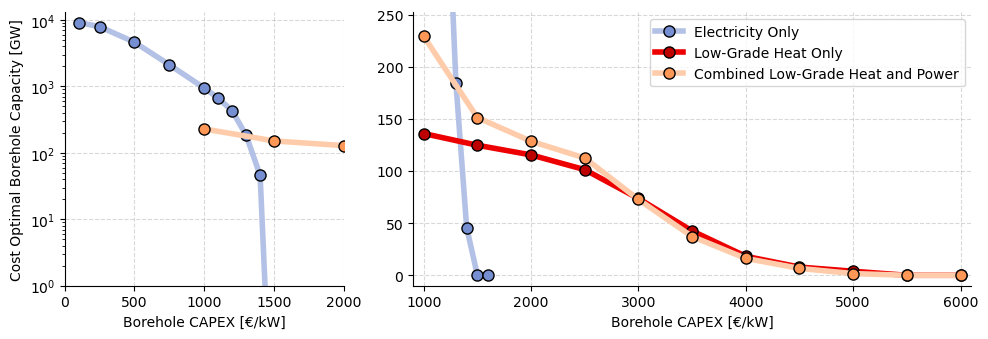

In [12]:
mode = "static"

assert mode in ["static", "both"]


def get_data(mode, op):

    index_col = [0,1,2]
    header = [0,1,2,3,4,5,6,7,8]

    if mode == "chp" or mode == "dh":
        df = pd.read_csv(
            root / f"{mode}_data" / 
            # f"csvs_{op}" / 
            "nodal_capacities.csv", 
            index_col=index_col,
            header=header,
            )

    elif mode == "elec":
        if op == "flex":
            df = pd.read_csv(
                root / f"elec_data_flex" / "nodal_capacities.csv",
                index_col=index_col,
                header=header,
            )
        else:
            df = pd.read_csv(
                root / f"{mode}_data" / "nodal_capacities.csv",
                index_col=index_col,
                header=header,
            )

    df = df.groupby(level=[0,2]).sum()

    df.columns = df.columns.droplevel([0,1,2,3,5,7,8])

    df["carrier"] = df.index.get_level_values(1)
    df.index = df.index.droplevel(1)

    df.index += " " + df.carrier

    return df.loc["links injection geothermal heat"].loc[idx[:, op]].mul(1e-3)


elec_static = get_data("elec", "static")
chp_static = get_data("chp", "static")
dh_static = get_data("dh", "static")

if mode == "both":
    elec_flex = get_data("elec", "flex")
    chp_flex = get_data("chp", "flex")
    dh_flex = get_data("dh", "flex")

if mode == "static":
    figsize = (10, 3.5)
elif mode == "both":
    figsize = (13, 4.5)

fig, axs = plt.subplots(1, 2, figsize=figsize, gridspec_kw={"width_ratios": [1, 2]})

# elec_static.plot.(ax=ax, stacked=True, width=0.8, edgecolor='black', linewidth=0.5)

labels = {
    # "elec static": "Electricity Only, Inflexible Operation",
    "elec static": "Electricity Only",
    # "elec flex": "Electricity Only, Operation with Storage",
    # "chp static": "Combined Heat and Power, Inflexible Operation",
    "chp static": "Combined Low-Grade Heat and Power",
    # "chp flex": "Combined Heat and Power, Operation with Storage",
    # "dh static": "District Heating, Inflexible Operation",
    "dh static": "Low-Grade Heat Only",
    # "dh flex": "District Heating, Operation with Storage",
}

line_kwargs = {
    "marker": 'o',
    "markersize": 8,
    "linewidth": 4.,
    "markeredgewidth": 1,
    "markeredgecolor": "k",
}

if mode == "both":
    line_kwargs.update({
        # "markersize": 5,
        "markersize": None,
        "marker": None,
        "linewidth": 3,
        "markeredgewidth": 0.5,
    })

axs[0].plot(
    elec_static.index.astype(int)[:-1],
    elec_static.values[:-1],
    color=colors["elec"],
    label=labels["elec static"],
    markerfacecolor=adjust_lightness(colors["elec"], 0.8),
    **line_kwargs
    )
axs[0].plot(
    chp_static.index.astype(int),
    chp_static.values,
    color=colors["chp"],
    label=labels["chp static"],
    markerfacecolor=adjust_lightness(colors["chp"], 0.8),
    **line_kwargs)
axs[0].set_yscale("log")

if mode == "both":

    axs[0].plot(
        elec_flex.index.astype(int)[:-1],
        elec_flex.values[:-1],
        color=colors["elec"],
        markerfacecolor=adjust_lightness(colors["elec"], 0.8),
        linestyle="--",
        **line_kwargs
        )
    axs[0].plot(
        chp_flex.index.astype(int),
        chp_flex.values,
        color=colors["chp"],
        # label=labels["chp static"],
        markerfacecolor=adjust_lightness(colors["chp"], 0.8),
        linestyle="--",
        **line_kwargs)
    axs[1].plot(
        elec_flex.index.astype(int),
        elec_flex.values,
        color=colors["elec"],
        # label=labels["elec static"],
        markerfacecolor=adjust_lightness(colors["elec"], 0.8),
        linestyle="--",
        **line_kwargs
        )
    axs[1].plot(
        dh_flex.index.astype(int),
        dh_flex.values, color=colors["dh"],
        # label=labels["dh static"],
        markerfacecolor=adjust_lightness(colors["dh"], 0.8),
        linestyle="--",
        **line_kwargs)
    axs[1].plot(
        chp_flex.index.astype(int),
        chp_flex.values,
        color=colors["chp"],
        # label=labels["chp static"],
        markerfacecolor=adjust_lightness(colors["chp"], 0.8),
        linestyle="--",
        **line_kwargs)


axs[1].plot(
    elec_static.index.astype(int),
    elec_static.values,
    color=colors["elec"],
    label=labels["elec static"],
    markerfacecolor=adjust_lightness(colors["elec"], 0.8),
    **line_kwargs
    )

# ax.plot(elec_flex.index.astype(int), elec_flex.values, color="orange", linestyle="--", **line_kwargs)
axs[1].plot(
    dh_static.index.astype(int),
    dh_static.values, color=colors["dh"],
    label=labels["dh static"],
    markerfacecolor=adjust_lightness(colors["dh"], 0.8),
    **line_kwargs)

axs[1].plot(
    chp_static.index.astype(int),
    chp_static.values,
    color=colors["chp"],
    label=labels["chp static"],
    markerfacecolor=adjust_lightness(colors["chp"], 0.8),
    **line_kwargs)


# ax.plot(chp_flex.index.astype(int), chp_flex.values, color="k", linestyle="--", **line_kwargs)
# ax.plot(dh_flex.index.astype(int), dh_flex.values, color="goldenrod", linestyle="--", **line_kwargs)
handles = axs[1].get_legend_handles_labels()

handles = []
labels = []

labels.append("Electricity Only")
handles.append(
    Line2D(
        [0], [0], color=colors["elec"],
        marker="o",
        markersize=8,
        linewidth=4,
        markeredgewidth=1,
        markeredgecolor="k",
        markerfacecolor=adjust_lightness(colors["elec"], 0.8),
        ))
    
labels.append("Low-Grade Heat Only")
handles.append(
    Line2D(
        [0], [0], color=colors["dh"],
        marker="o",
        markersize=8,
        linewidth=4,
        markeredgewidth=1,
        markeredgecolor="k",
        markerfacecolor=adjust_lightness(colors["dh"], 0.8),
    ))
labels.append("Combined Low-Grade Heat and Power")
handles.append(
    Line2D(
        [0], [0], color=colors["chp"],
        marker="o",
        markersize=8,
        linewidth=4,
        markeredgewidth=1,
        markeredgecolor="k",
        markerfacecolor=adjust_lightness(colors["chp"], 0.8),
    ))

if mode == "both":
    handles = (
        handles[0] + [
        Line2D([0], [0], color='white', lw=0, label=''),
        Line2D([0], [0], color='k', lw=1.5, label='Standard Operation'),
        Line2D([0], [0], color='k', lw=1.5, linestyle="--", label='Flexible Operation'),
        ]
    )

axs[1].legend(handles=handles, labels=labels, loc="upper right") 


# axs[0].legend(loc="lower left")

# ax.set_ylim(-50, 3000)
axs[1].set_xlim(900, 6102)
# axs[1].set_ylim(-10, 162)
axs[1].set_ylim(-10, 252)
# ax.set_xlim(2900, 9100)
axs[0].set_ylim(1e-0, 1.3e4)
axs[0].set_xlim(0, 2000)

axs[0].set_ylabel("Cost Optimal Borehole Capacity [GW]")
axs[0].set_xlabel("Borehole CAPEX [{}/kW]".format(u"\N{euro sign}"))
axs[1].set_xlabel("Borehole CAPEX [{}/kW]".format(u"\N{euro sign}"))

for ax in axs:
    ax.grid(linestyle="--", color="grey", alpha=0.3)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

plt.tight_layout()

tikzplotlib.save("main_plot.tex")
plt.savefig("main_plot.pdf")

plt.show()